In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [58]:
# --- Cài đặt cấu hình trực quan hóa ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
# Đảm bảo bạn có biến 'data' (mảng NumPy có cấu trúc)

In [27]:
input_file = r"..\data\raw\vaccination_tweets.csv" 
output_file  = r"..\data\raw\pfizer_tweets_clean.csv" 

clean_rows = []
current = ""
inside_quote = False

with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        # Bỏ ký tự xuống dòng ở cuối
        l = line.rstrip("\n")

        # Đếm số dấu " trong dòng
        quote_count = l.count('"')

        # Nếu chưa ở trong quote, thêm dòng mới
        if not inside_quote:
            current = l
        else:
            current += "\\n" + l   # nối dòng tweet bị xuống dòng

        # Cập nhật trạng thái quote
        if quote_count % 2 == 1:   # số lẻ → bật/tắt quote
            inside_quote = not inside_quote

        # Nếu đã đóng quote → dòng hoàn chỉnh
        if not inside_quote:
            clean_rows.append(current)

# === BƯỚC 2: Thay dấu phẩy trong "..." thành ; ===

def replace_commas(match):
    inner = match.group(0)[1:-1]      # bỏ dấu "
    inner = inner.replace(",", ";")   # thay đổi
    return f'"{inner}"'

final_rows = []
for row in clean_rows:
    row2 = re.sub(r'"[^"]*"', replace_commas, row)
    final_rows.append(row2)


with open(output_file, "w", encoding="utf-8") as f:
    for r in final_rows:
        f.write(r + "\n")


In [28]:
data = np.genfromtxt(
    r"..\data\raw\pfizer_tweets_clean.csv", 
    delimiter=',',
    dtype=None,
    names=True,
    encoding='utf-8',
    comments=None,
    converters={
        3: lambda x: x.decode('utf-8') if isinstance(x, bytes) else str(x),  # user_description
        10: lambda x: x.decode('utf-8') if isinstance(x, bytes) else str(x), # text
        11: lambda x: x.decode('utf-8') if isinstance(x, bytes) else str(x)  # hashtags
    },
    missing_values='',
    filling_values= None

)


print("\n5 dòng đầu tiên:")
print("Header: ", data.dtype.names)
for i in range(min(10, len(data))):
    print(f"Row {i}: {data[i]}")




5 dòng đầu tiên:
Header:  ('id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet')
Row 0: (1340539111971516416, 'Rachel Roh', '"La Crescenta-Montrose; CA"', '"Aggregator of Asian American news; scanning diverse sources 24/7/365. RT\'s; Follows and \'Likes\' will fuel me 👩\u200d💻"', '2009-04-08 17:52:46', 405, 1692, 3247, False, '2020-12-20 06:06:44', 'Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF', "['PfizerBioNTech']", 'Twitter for Android', 0, 0, False)
Row 1: (1338158543359250433, 'Albert Fong', '"San Francisco; CA"', '"Marketing dude; tech geek; heavy metal & \'80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own."', '2009-09-21 15:27:30', 834, 666, 178, False, '2020-12-13 16:27:13', '"While the world has been on the wrong side of

In [29]:
print("Số cột:", len(data.dtype.names))
print("Số hàng: ", len(data))

Số cột: 16
Số hàng:  11020


In [30]:
print("Tên các cột")
data.dtype.names

Tên các cột


('id',
 'user_name',
 'user_location',
 'user_description',
 'user_created',
 'user_followers',
 'user_friends',
 'user_favourites',
 'user_verified',
 'date',
 'text',
 'hashtags',
 'source',
 'retweets',
 'favorites',
 'is_retweet')

In [31]:
print("Các kiểu dữ liệu của các cột")
data.dtype.descr

Các kiểu dữ liệu của các cột


[('id', '<i8'),
 ('user_name', '<U52'),
 ('user_location', '<U120'),
 ('user_description', '<U229'),
 ('user_created', '<U19'),
 ('user_followers', '<i8'),
 ('user_friends', '<i8'),
 ('user_favourites', '<i8'),
 ('user_verified', '|b1'),
 ('date', '<U19'),
 ('text', '<U156'),
 ('hashtags', '<U140'),
 ('source', '<U31'),
 ('retweets', '<i8'),
 ('favorites', '<i8'),
 ('is_retweet', '|b1')]

In [32]:
ta thấy rằng ở cột `user_created`, `date` là kiểu str nên ta phải chuyển sang dạng ngày tháng

SyntaxError: invalid syntax (3430230952.py, line 1)

In [33]:
user_created_str = data['user_created']
date_str = data['date']

# Chuyển đổi sang datetime
user_created_dt = user_created_str.astype('datetime64[s]')
date_dt = date_str.astype('datetime64[s]')


new_dtype = data.dtype.descr  
new_dtype_list = list(new_dtype) 

for i, (name, dtype) in enumerate(new_dtype_list):
    if name == 'user_created' or name == 'date':
        new_dtype_list[i] = (name, 'datetime64[s]') 
        
new_data = np.empty(data.shape, dtype=new_dtype_list)

# Sao chép các trường cũ và gán các trường mới
for name in data.dtype.names:
    if name != 'user_created' and name != 'date':
        new_data[name] = data[name]

new_data['user_created'] = user_created_dt
new_data['date'] = date_dt

print("Kiểu dữ liệu mới của cột 'user_created':", new_data['user_created'].dtype)
print("Kiểu dữ liệu mới của cột 'date':", new_data['date'].dtype)

Kiểu dữ liệu mới của cột 'user_created': datetime64[s]
Kiểu dữ liệu mới của cột 'date': datetime64[s]


In [ ]:


print(f"{'Cột':<30}{'Số Lượng Thiếu':>15}{'Tỉ Lệ Thiếu':>15}")
print("-" * 60)

total_rows = len(data)

for col_name in data.dtype.names:
    col_data = data[col_name]
    missing_count = 0
    
    # Kiểm tra kiểu dữ liệu của cột
    dtype_kind = col_data.dtype.kind
    
    if dtype_kind in 'fi': # f: float i: integer 
        # Đối với cột số, kiểm tra np.nan
        if dtype_kind == 'i':
            pass
        try:
            missing_count = np.sum(np.isnan(col_data))
        except TypeError:
            pass
             
    elif dtype_kind in 'SU': # S: string/bytes; U: unicode string
        # kiểm tra chuỗi rỗng ('')
        
        is_empty_string = (col_data == b'') # Kiểm tra cho bytes (S)
        is_empty_unicode = (col_data == '') # Kiểm tra cho Unicode (U)

        missing_count = np.sum(is_empty_string) + np.sum(is_empty_unicode)

    # In kết quả nếu có giá trị thiếu
    if missing_count > 0:
        missing_percentage = (missing_count / total_rows) * 100
        print(f"{col_name:<30}{missing_count:>15}{missing_percentage:>15.2f}%")

print("-" * 60)




Cột                            Số Lượng Thiếu    Tỉ Lệ Thiếu
------------------------------------------------------------
user_location                            2270          20.60%
user_description                          679           6.16%
hashtags                                 2582          23.43%
source                                      1           0.01%
------------------------------------------------------------


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17920\2896886457.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates, y=cols, palette='viridis')


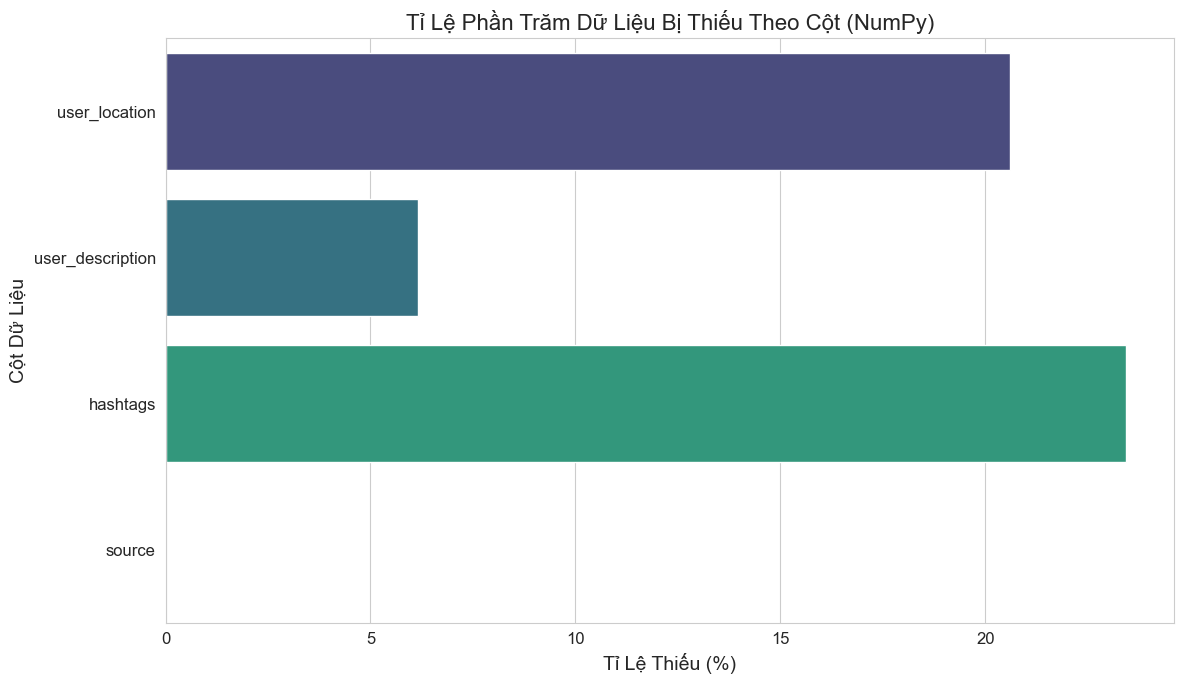

In [ ]:
# --- Tính toán tỉ lệ thiếu chỉ dùng NumPy ---
missing_data = {}
total_rows = len(data)

for col_name in data.dtype.names:
    col_data = data[col_name]
    missing_count = 0
    dtype_kind = col_data.dtype.kind
    
    if dtype_kind in 'fi': 
        try:
            # np.sum(np.isnan) đếm NaN cho cột số
            missing_count = np.sum(np.isnan(col_data))
        except TypeError:
             pass
    elif dtype_kind in 'SU': 
        # Đếm chuỗi rỗng ('') cho cột văn bản
        is_empty_unicode = (col_data == '') 
        is_empty_bytes = (col_data == b'') 
        missing_count = np.sum(is_empty_unicode) + np.sum(is_empty_bytes)
    
    if missing_count > 0:
        missing_data[col_name] = (missing_count / total_rows) * 100

# Tạo mảng để vẽ biểu đồ
if missing_data:
    cols = list(missing_data.keys())
    rates = list(missing_data.values())
    
    plt.figure(figsize=(12, 7))
    sns.barplot(x=rates, y=cols, palette='viridis')
    
    plt.title('Tỉ Lệ Phần Trăm Dữ Liệu Bị Thiếu Theo Cột (NumPy)', fontsize=16)
    plt.xlabel('Tỉ Lệ Thiếu (%)', fontsize=14)
    plt.ylabel('Cột Dữ Liệu', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu bị thiếu để trực quan hóa.")

In [ ]:
Khám phá xem các trường số như 'user_followers', 'user_friends', 'user_favourites', 'retweets', 'favorites'

In [41]:
numerical_col = ['user_followers', 'user_friends', 'user_favourites', 'retweets', 'favorites']

print(f"{'Column Name':<20}{'Min':>12}{'Max':>12}{'Mean':>14}{'Median':>12}{'Q1':>12}{'Q3':>12}")
print("-" * 95)
for col in numerical_col:
    col_data = new_data[col]
    min_val = np.min(col_data)
    max_val = np.max(col_data)
    mean_val = np.mean(col_data)
    median_val = np.median(col_data)
    Q1 = np.quantile(col_data, 0.25)
    Q3 = np.quantile(col_data, 0.75)

    
   
    print(
        f"{col:<20}"
        f"{min_val:>12.0f}"  
        f"{max_val:>12.0f}"
        f"{mean_val:>14.2f}"
        f"{median_val:>12.2f}"
        f"{Q1:>12.2f}"
        f"{Q3:>12.2f}"

    )

Column Name                  Min         Max          Mean      Median          Q1          Q3
-----------------------------------------------------------------------------------------------
user_followers                 0    13714928      35188.27      479.00      111.00     2171.25
user_friends                   0      103226       1170.47      460.00      164.00     1221.00
user_favourites                0     1213794      15332.89     2323.50      436.00    11140.75
retweets                       0         678          1.36        0.00        0.00        1.00
favorites                      0        2315          7.51        1.00        0.00        4.00


In [ ]:
numerical_col = ['user_followers', 'user_friends', 'user_favourites', 'retweets', 'favorites']

# --- Chuẩn bị dữ liệu (loại bỏ NaN) ---
# Tạo một danh sách các mảng sạch để vẽ Box Plot
plot_data = []
clean_cols = []
for col in numerical_col:
    col_data = data[col]

    
    if len(col_data) > 0:
        plot_data.append(col_data)
        clean_cols.append(col)

# --- Vẽ Box Plot ---
plt.figure(figsize=(15, 7))
# Cần chuyển plot_data thành một mảng 2D cho Matplotlib/Seaborn nếu không dùng Pandas
# Ở đây ta dùng hàm boxplot của Matplotlib trực tiếp trên danh sách các mảng
plt.boxplot(plot_data, vert=False, labels=clean_cols, notch=True, patch_artist=True)

plt.title('Box Plot Phân Phối Các Cột Số (Phát hiện Outliers)', fontsize=16)
plt.xlabel('Giá Trị (Dùng Log Scale)', fontsize=14)
plt.yticks(fontsize=12)

# Thiết lập log scale cho trục X vì dữ liệu như followers thường rất lệch
ax = plt.gca()
ax.set_xscale('log') 

plt.tight_layout()
plt.show()

In [55]:

date_col = new_data['date']

if len(date_col) > 0:
    min_date = np.min(date_col)
    max_date = np.max(date_col)
    
    print(f"Ngày Tweet Sớm nhất: {min_date}")
    print(f"Ngày Tweet Muộn nhất: {max_date}")
    

    data_range = max_date - min_date
    print(f"Phạm vi thu thập: {data_range}")

print()
user_created_col = new_data['user_created']

if len(user_created_col) > 0:
    min_created = np.min(user_created_col)
    max_created = np.max(user_created_col)
    

    print(f"Ngày Tạo Tài Khoản Sớm nhất: {min_created}")
    print(f"Ngày Tạo Tài Khoản Muộn nhất: {max_created}")




Ngày Tweet Sớm nhất: 2020-12-12T11:55:28
Ngày Tweet Muộn nhất: 2021-11-23T20:30:48
Phạm vi thu thập: 29925320 seconds

Ngày Tạo Tài Khoản Sớm nhất: 2006-07-15T21:06:00
Ngày Tạo Tài Khoản Muộn nhất: 2021-11-18T22:02:07


In [54]:
# Tính toán Tuổi tài khoản (Duration/Timedelta)
account_age = new_data['date'] - new_data['user_created']


print(f"Tuổi tài khoản Trung bình (Mean Age): {np.mean(account_age)}")
print(f"Tuổi tài khoản Trung vị (Median Age): {np.median(account_age)}")
print(f"Tuổi tài khoản Nhỏ nhất (Min Age): {np.min(account_age)}")
print(f"Tuổi tài khoản Lớn nhất (Max Age): {np.max(account_age)}")


Tuổi tài khoản Trung bình (Mean Age): 218846684 seconds
Tuổi tài khoản Trung vị (Median Age): 247613897 seconds
Tuổi tài khoản Nhỏ nhất (Min Age): 139 seconds
Tuổi tài khoản Lớn nhất (Max Age): 468092511 seconds


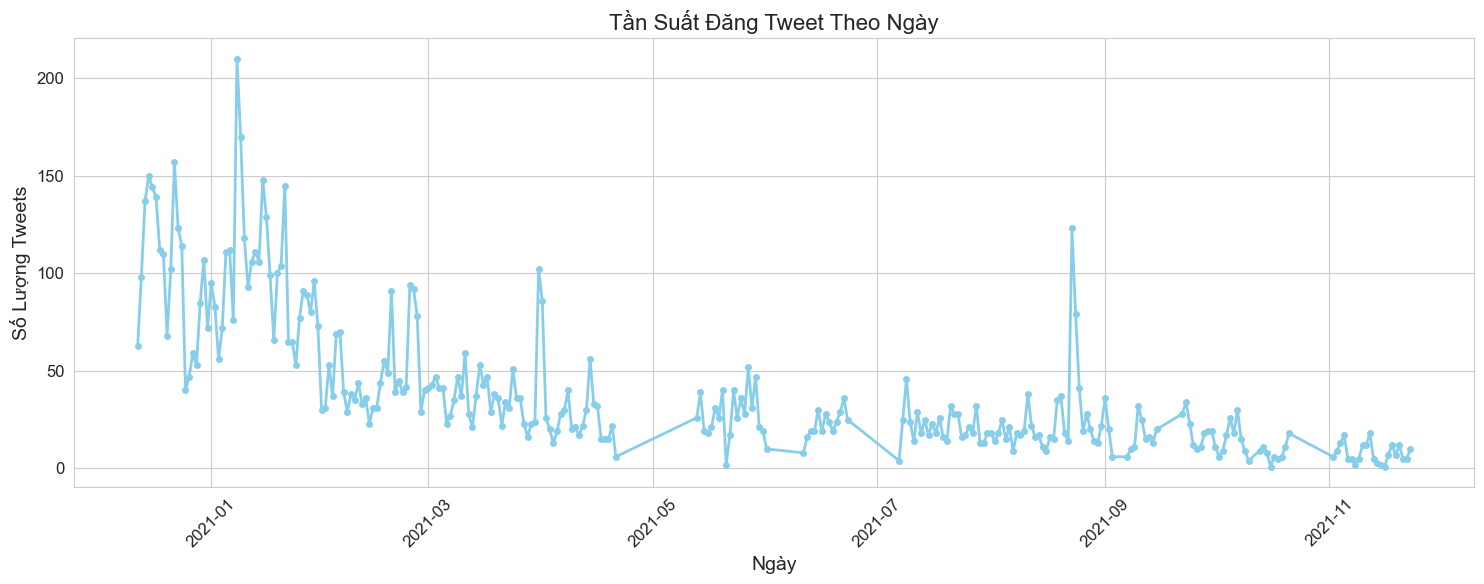

In [63]:
# --- GIẢ ĐỊNH: Cột 'date' là datetime64 ---
date_col = data['date']

# 1. Tính toán tần suất theo ngày (hoặc giờ)
# Chuyển đổi datetime64 thành số ngày/số giờ kể từ một mốc nào đó (epoch)
# Lọc bỏ Not a Time (NaT)

if len(date_col) > 0:
    # Chuyển đổi datetime64 sang số ngày (để nhóm)
    dates_as_days = date_col.astype('datetime64[D]')

    # 2. Đếm tần suất mỗi ngày (chỉ dùng NumPy)
    unique_dates, counts = np.unique(dates_as_days, return_counts=True)
    
    # Chuyển lại các ngày duy nhất thành datetime objects để vẽ biểu đồ
    unique_dates_dt = unique_dates.astype(object)
    
    # --- Vẽ Biểu đồ Đường (Line Plot) ---
    plt.figure(figsize=(15, 6))
    plt.plot(unique_dates_dt, counts, marker='o', linestyle='-', color='skyblue', linewidth=2, markersize=4)
    
    plt.title('Tần Suất Đăng Tweet Theo Ngày', fontsize=16)
    plt.xlabel('Ngày', fontsize=14)
    plt.ylabel('Số Lượng Tweets', fontsize=14)
    plt.xticks(rotation=45) # Xoay nhãn ngày để dễ đọc
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu thời gian hợp lệ để trực quan hóa.")

In [48]:
# Tính tỷ lệ người dùng verified
verified_ratio = np.sum(data['user_verified']) / total_rows * 100
print(f"Tỷ lệ tài khoản được xác minh: {verified_ratio:.2f}%")

# Tính tỷ lệ retweet
retweet_ratio = np.sum(data['is_retweet']) / total_rows * 100
print(f"Tỷ lệ Tweet là retweet: {retweet_ratio:.2f}%")


Tỷ lệ tài khoản được xác minh: 8.49%
Tỷ lệ Tweet là retweet: 0.00%


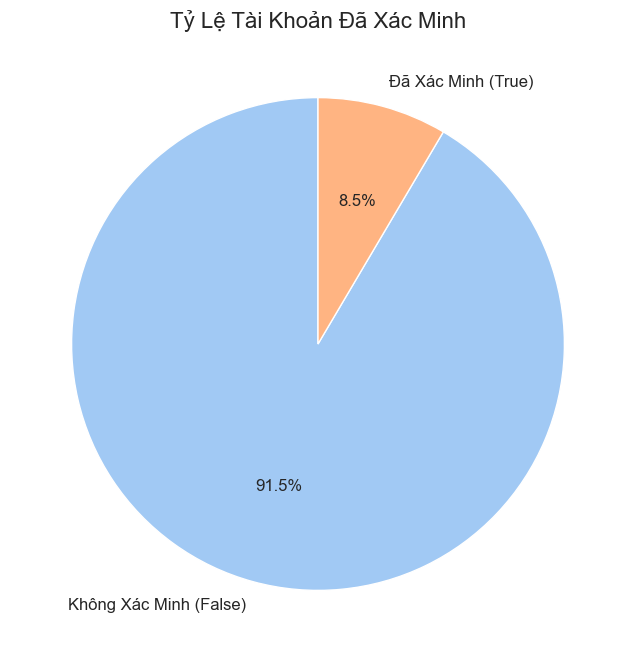

In [64]:
verified_counts = np.unique(data['user_verified'], return_counts=True)

if len(verified_counts[0]) == 2: # Đảm bảo có cả True và False
    verified_ratio = verified_counts[1]
    labels = ['Không Xác Minh (False)', 'Đã Xác Minh (True)']
    
    plt.figure(figsize=(8, 8))
    # Biểu đồ tròn (Pie Chart) rất sinh động cho tỉ lệ
    plt.pie(verified_ratio, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Tỷ Lệ Tài Khoản Đã Xác Minh', fontsize=16)
    plt.show()
else:
    print("Không đủ dữ liệu Boolean cho cột 'user_verified' để vẽ biểu đồ tròn.")

In [68]:


source_col = data['source']

# Sử dụng np.unique() để tìm tất cả các giá trị duy nhất
unique_sources = np.unique(source_col)

# Đếm số lượng giá trị duy nhất
num_unique_sources = len(unique_sources)

print(f"Tổng số lượng các giá trị (nguồn) duy nhất trong cột 'source' là: {num_unique_sources}")

print(unique_sources)

Tổng số lượng các giá trị (nguồn) duy nhất trong cột 'source' là: 65
['' '24liveblog' 'Article Tweetbot' 'BizToc' 'BizToc News'
 'Blog2Social APP' 'Buffer' 'Business Upturn' 'Canva' 'CoSchedule'
 'ETRetail.com' 'EastMojo' 'Echobox' 'Echofon'
 'Falcon Social Media Management ' 'Fenix 2' 'Flying Eze' 'GT_Backend'
 'Hash#trends' 'Hocalwire Social Share' 'Hootsuite Inc.' 'Hypefury'
 'IFTTT' 'Imminent News' 'Instagram' 'LaterMedia' 'LinkedIn' 'Loomly'
 'Microsoft Power Platform' 'Nelio Content' 'News Medical' 'News Users'
 'Nonli' 'Paper.li' 'Publer ' 'Revive Social App'
 'SEMrush Social Media Tool' 'Salesforce - Social Studio' 'Sendible'
 'Social-Pull-Staging' 'SocialBee.io v2' 'SocialFlow' 'SocialNewsDesk'
 'Socialbakers' 'Sprinklr' 'Sprinklr Publishing' 'Sprout Social'
 'The Tweeted Times' 'ThreadReaderApp' 'Threader_client' 'Tumblr'
 'TweetCaster for Android' 'TweetDeck' 'Tweetbot for Mac'
 'Tweetbot for iΟS' 'Twitter Media Studio'
 'Twitter Media Studio - LiveCut' 'Twitter Web App' 'Tw

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17920\3218485942.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=all_sorted_counts, y=all_sorted_sources, palette='Paired')


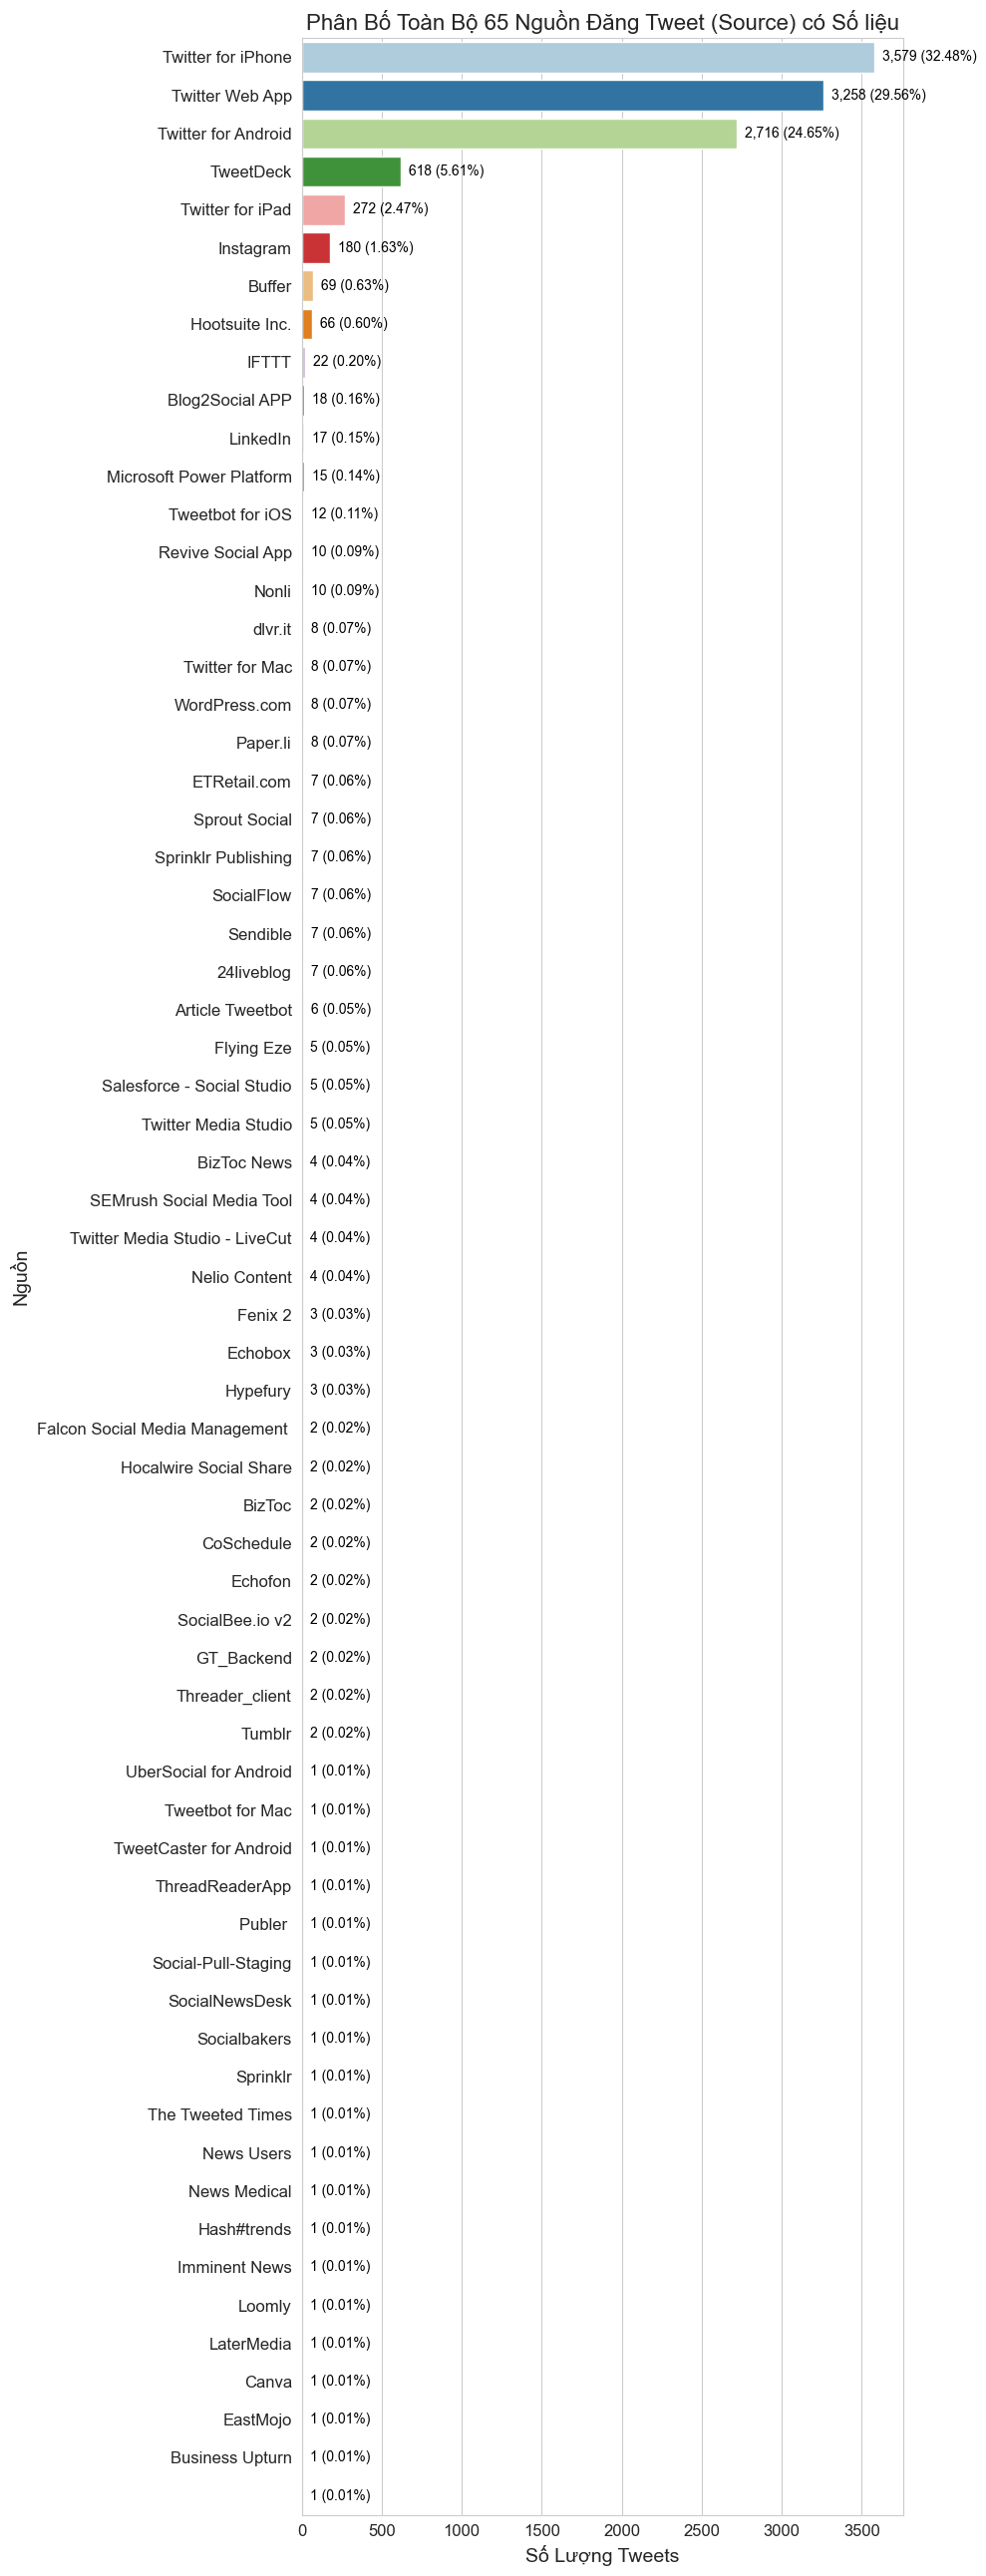

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Giả định 'data' là mảng NumPy có cấu trúc đã được tải
source_col = data['source']
unique_sources, counts = np.unique(source_col, return_counts=True)
total_rows = len(data) # Tổng số lượng bản ghi

# 1. Sắp xếp tất cả các nguồn theo số lượng giảm dần
sorted_indices = np.argsort(counts)[::-1]
all_sorted_sources_bytes = unique_sources[sorted_indices]
all_sorted_counts = counts[sorted_indices]

# 2. Chuyển byte string sang Unicode string để hiển thị trên biểu đồ
all_sorted_sources = [s.decode('utf-8') if isinstance(s, bytes) else s for s in all_sorted_sources_bytes]

# 3. Cấu hình và vẽ biểu đồ thanh
num_sources = len(all_sorted_sources)
fig_height = max(6, num_sources * 0.4) 

plt.figure(figsize=(10, fig_height))
# Tạo biểu đồ thanh ngang và lưu trục (axis) vào biến 'ax'
ax = sns.barplot(x=all_sorted_counts, y=all_sorted_sources, palette='Paired')

# 4. THÊM CHÚ THÍCH SỐ LƯỢNG VÀ TỈ LỆ (%)
for i, count in enumerate(all_sorted_counts):
    percentage = (count / total_rows) * 100
    # Định dạng chuỗi hiển thị: Số lượng (Tỉ lệ %)
    # Sử dụng dấu phẩy (,) cho số lớn và 2 chữ số thập phân cho %
    text = f'{count:,.0f} ({percentage:.2f}%)' 
    
    # Thêm văn bản vào cuối thanh (x=count, y=i)
    # x=count + (một khoảng padding nhỏ)
    ax.text(
        count + 50, # Đặt vị trí X nhích sang phải một chút
        i,          # Chỉ mục Y (vị trí thanh)
        text, 
        color='black', 
        ha='left', 
        va='center', 
        fontsize=10
    )

plt.title(f'Phân Bố Toàn Bộ {num_sources} Nguồn Đăng Tweet (Source) có Số liệu', fontsize=16)
plt.xlabel('Số Lượng Tweets', fontsize=14)
plt.ylabel('Nguồn', fontsize=14)
plt.tight_layout()
plt.show()

Phân tích Độ dài Tweet...
Độ dài Tweet Trung bình: 129.44 ký tự
Độ dài Tweet Trung vị: 140 ký tự
Tweet dài nhất: 156 ký tự
Đã lưu tweet_length_histogram.png


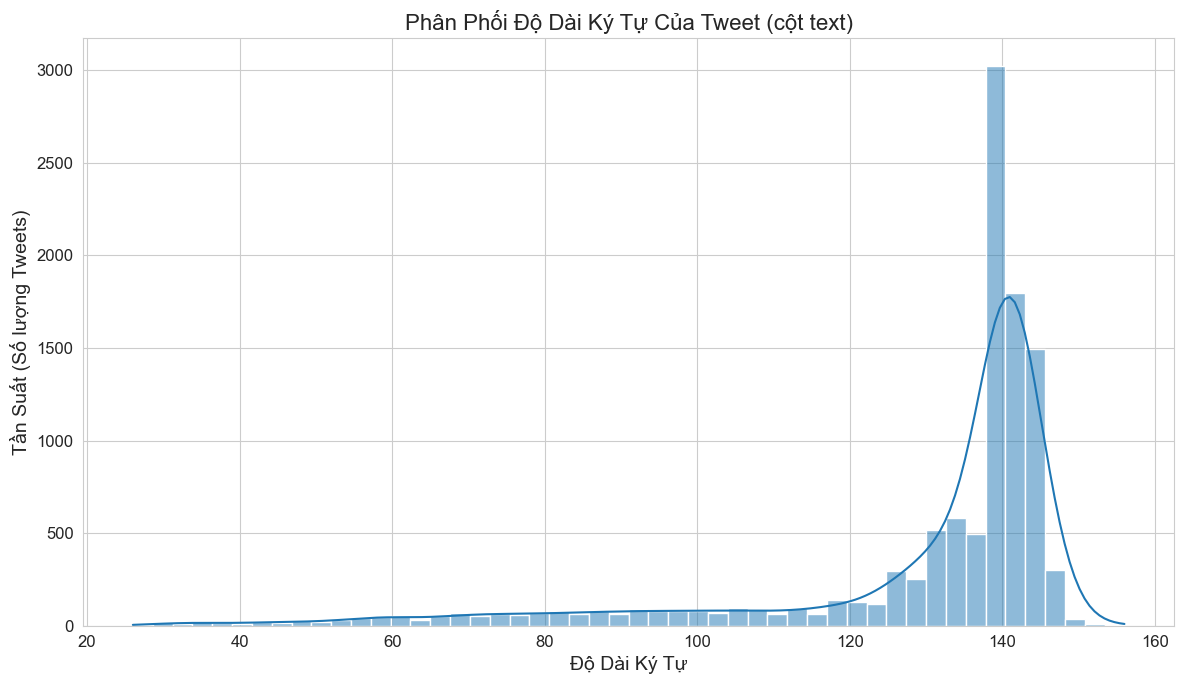

In [ ]:
# --- BƯỚC 3: Khám phá Dữ liệu Văn bản (Độ dài Tweet) ---
print("Phân tích Độ dài Tweet...")
text_col = new_data['text']
# Sử dụng np.char.str_len để lấy độ dài (hoạt động trên mảng NumPy)
tweet_lengths = np.char.str_len(text_col)

# Lọc bỏ các tweet rỗng (độ dài 0)
valid_lengths = tweet_lengths[tweet_lengths > 0]

print(f"Độ dài Tweet Trung bình: {np.mean(valid_lengths):.2f} ký tự")
print(f"Độ dài Tweet Trung vị: {np.median(valid_lengths):.0f} ký tự")
print(f"Tweet dài nhất: {np.max(valid_lengths)} ký tự")

plt.figure(figsize=(12, 7))
sns.histplot(valid_lengths, bins=50, kde=True)
plt.title('Phân Phối Độ Dài Ký Tự Của Tweet (cột text)', fontsize=16)
plt.xlabel('Độ Dài Ký Tự', fontsize=14)
plt.ylabel('Tần Suất (Số lượng Tweets)', fontsize=14)
plt.tight_layout()


Phân tích Hashtags...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17920\3754215691.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette='viridis')


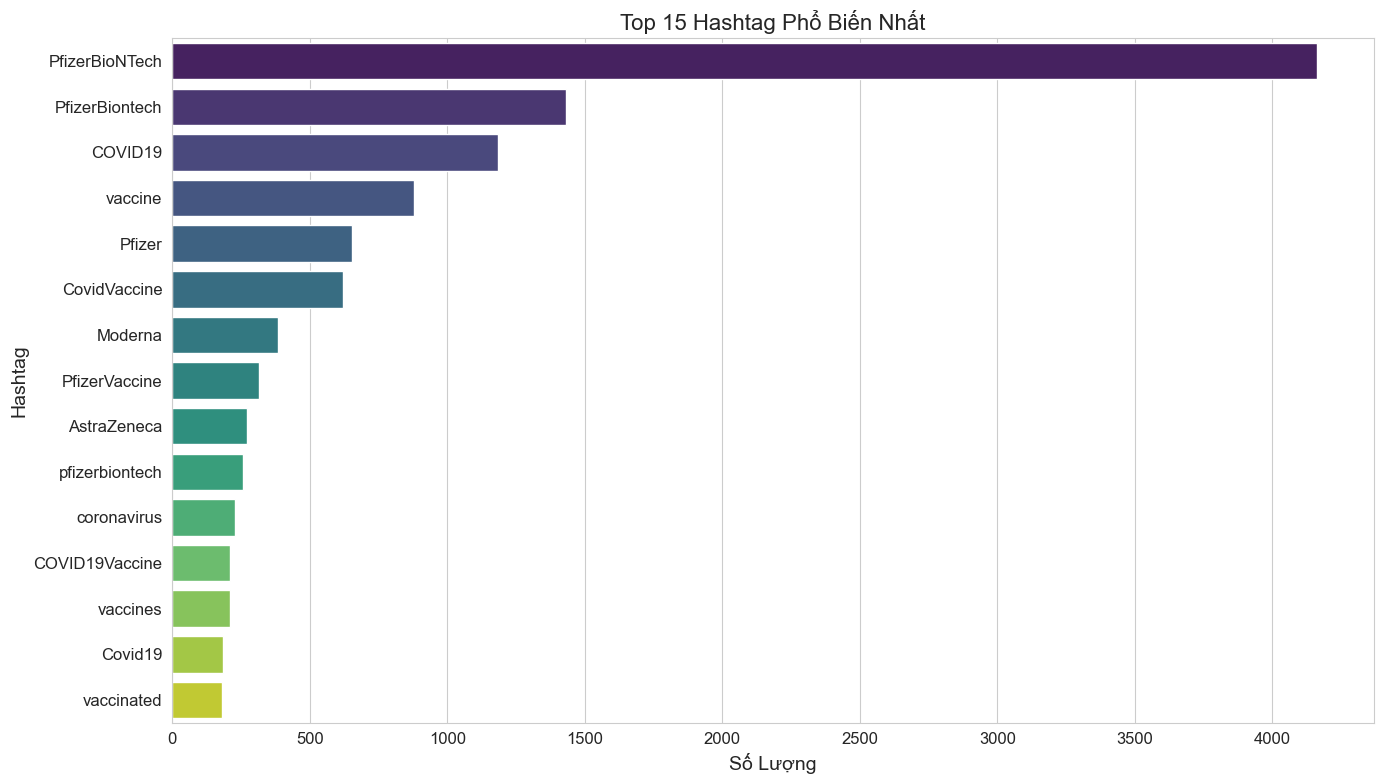

In [79]:
# --- BƯỚC 4: Khám phá Dữ liệu Văn bản (Hashtags) ---
print("Phân tích Hashtags...")
hashtag_counter = Counter()
hashtag_col = new_data['hashtags']

for h_list_str in hashtag_col:
    # Làm sạch chuỗi: loại bỏ '[', ']', '"', "'" và khoảng trắng
    cleaned_str = str(h_list_str).strip("[]'\" ")
    
    if cleaned_str: # Chỉ xử lý nếu chuỗi không rỗng
        # Tách chuỗi bằng dấu phẩy (và có thể có dấu cách)
        tags = re.split(r"[',;]\s*", cleaned_str)
        
        # Cập nhật bộ đếm (lọc bỏ các chuỗi rỗng có thể xuất hiện sau khi split)
        hashtag_counter.update(tag for tag in tags if tag)

# Lấy 15 hashtag phổ biến nhất
top_15_hashtags = hashtag_counter.most_common(15)

if top_15_hashtags:
    # Tách nhãn và số lượng để vẽ biểu đồ
    labels = [tag[0] for tag in top_15_hashtags]
    counts = [tag[1] for tag in top_15_hashtags]

    plt.figure(figsize=(14, 8))
    sns.barplot(x=counts, y=labels, palette='viridis')
    plt.title('Top 15 Hashtag Phổ Biến Nhất', fontsize=16)
    plt.xlabel('Số Lượng', fontsize=14)
    plt.ylabel('Hashtag', fontsize=14)
    plt.tight_layout()

else:
    print("Không tìm thấy hashtag nào để phân tích.")

In [84]:
import numpy as np

# Giả định: 'data' là mảng NumPy có cấu trúc (structured array) của bạn
location_col = data['user_location']

# --- BƯỚC 1: Lọc bỏ giá trị rỗng (tương đương với Pandas loại bỏ NaN/None) ---
# Kiểm tra cả chuỗi byte rỗng (b'') và chuỗi unicode rỗng ('')
valid_locations = location_col[(location_col != b'') & (location_col != '')]

# --- BƯỚC 2: Đếm tần suất các giá trị duy nhất ---
# return_counts=True là chức năng cốt lõi của value_counts()
unique_values, counts = np.unique(valid_locations, return_counts=True)

# --- BƯỚC 3: Sắp xếp theo tần suất giảm dần ---
# np.argsort(counts) cho index sắp xếp tăng dần. [::-1] đảo ngược để giảm dần.
sorted_indices = np.argsort(counts)[::-1]

# Sắp xếp lại giá trị duy nhất và số đếm
sorted_unique_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

# --- IN KẾT QUẢ (Ví dụ in 10 giá trị hàng đầu) ---
print("--- NumPy Equivalent of df['user_location'].value_counts() (Top 10) ---")

for value, count in zip(sorted_unique_values[:], sorted_counts[:]):
    # Giải mã chuỗi byte sang chuỗi thường (nếu cần)
    display_value = value.decode('utf-8') if isinstance(value, bytes) else str(value)
    print(f"{display_value:<30} {count}")

print(f"\n... (Tổng số vị trí duy nhất không rỗng: {len(unique_values)})")

--- NumPy Equivalent of df['user_location'].value_counts() (Top 10) ---
Malaysia                       168
"London; England"              142
India                          127
Petaling Jaya                  106
London                         95
Canada                         90
Hong Kong                      80
United Kingdom                 77
"Weinheim; Germany"            76
United Arab Emirates           73
United States                  66
"Dubai; United Arab Emirates"  66
"Mumbai; India"                60
"New Delhi; India"             59
Singapore                      57
"Toronto; Ontario"             57
Ireland                        50
Ragbag Of Reviews And Insights 49
#KeepFightingMichael           45
Global                         43
"England; United Kingdom"      43
"Chicago; IL"                  43
Earth                          42
Cornwall UK                    41
Glasgow environs.              41
Qatar                          39
UK                             39
"Londo

Phân tích Top 15 User Locations...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17920\1179871101.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts, y=top_labels, palette='magma')


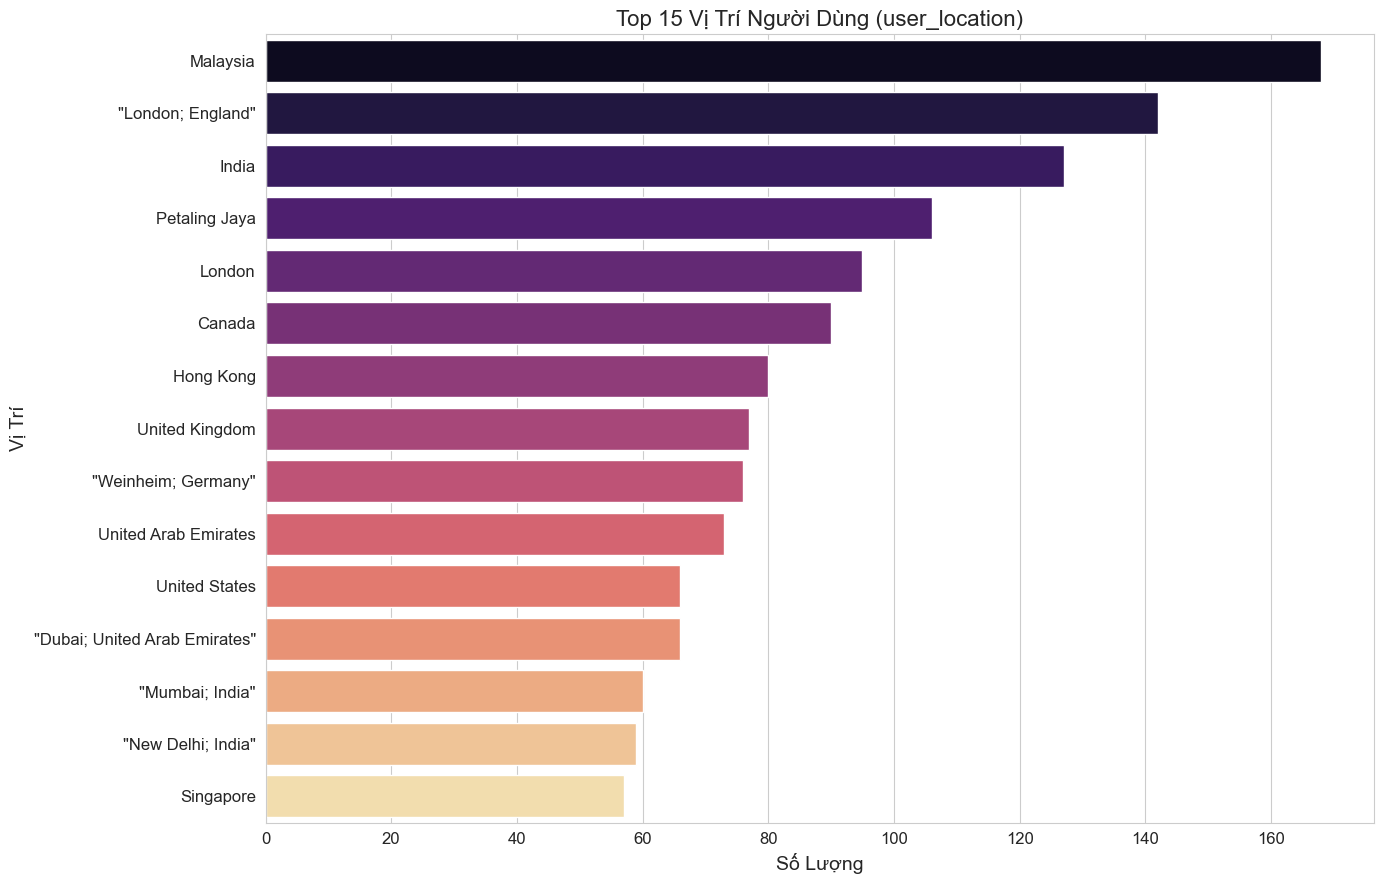

In [82]:
print("Phân tích Top 15 User Locations...")
location_col = new_data['user_location']

# Lọc bỏ các giá trị rỗng (bytes hoặc string)
valid_locations = location_col[(location_col != b'') & (location_col != '')]

if len(valid_locations) > 0:
    unique_locs, counts = np.unique(valid_locations, return_counts=True)

# Sắp xếp để lấy Top 15
sorted_indices = np.argsort(counts)[::-1]
top_15_indices = sorted_indices[:15]

top_labels_bytes = unique_locs[top_15_indices]
# Giải mã bytes sang string để hiển thị
top_labels = [loc.decode('utf-8') if isinstance(loc, bytes) else str(loc) for loc in top_labels_bytes]
top_counts = counts[top_15_indices]

plt.figure(figsize=(14, 9))
sns.barplot(x=top_counts, y=top_labels, palette='magma')
plt.title('Top 15 Vị Trí Người Dùng (user_location)', fontsize=16)
plt.xlabel('Số Lượng', fontsize=14)
plt.ylabel('Vị Trí', fontsize=14)
plt.tight_layout()